## Modeling of bank failures by FDIC 

**Instructions:**
- You will be using Python 3.
- Avoid using for-loops and while-loops, unless you are explicitly told to do so.
- Do not modify the (# GRADED FUNCTION [function name]) comment in some cells. Your work would not be graded if you change this. Each cell containing that comment should only contain one function.
- After coding your function, run the cell right below it to check if your result is correct.
- The token generated by Coursera (COURSERA_TOKEN) expires every <b>30 minutes</b>. It is advisable to always work with the most recent generated token so as to avoid any submission related errors. If you receive such error messages, rerun the cells containing your code and the GRADED FUNCTION in the same order. 


## About iPython Notebooks ##

iPython Notebooks are interactive coding environments embedded in a webpage. You will be using iPython notebooks in this class. You only need to write code between the ### START CODE HERE ### and ### END CODE HERE ### comments. After writing your code, you can run the cell by either pressing "SHIFT"+"ENTER" or by clicking on "Run Cell" (denoted by a play symbol) in the upper bar of the notebook. 

We will often specify "(≈ X lines of code)" in the comments to tell you about how much code you need to write. It is just a rough estimate, so don't feel bad if your code is longer or shorter.

In [1]:
import pandas as pd
import numpy as np
import time

import os
import functools
import math
import random
import sys, getopt
import sklearn

sys.path.append("..")
import grading

try:
    import matplotlib.pyplot as plt
    %matplotlib inline
except:
    pass
print('scikit-learn version:', sklearn.__version__)

scikit-learn version: 0.18.2


In [2]:
### ONLY FOR GRADING. DO NOT EDIT ###
submissions=dict()
assignment_key="7VcH6P8REeeRWA42vRAjYg" 
all_parts=["o5YYT", "2cHUA", "Mxrav", "JFNf3", "ivHQa"]
### ONLY FOR GRADING. DO NOT EDIT ###

In [91]:
# token expires every 30 min
COURSERA_TOKEN = 'Oe2Q8ZGTgFR5qIcg'# the key provided to the Student under his/her email on submission page
COURSERA_EMAIL = 'pranavk.ec@nsit.net.in'# the email

In [4]:
# common cell - share this across notebooks
state_cols = ['log_TA','NI_to_TA', 'Equity_to_TA', 'NPL_to_TL', 'REO_to_TA', 
              'ALLL_to_TL', 'core_deposits_to_TA', 'brokered_deposits_to_TA', 
              'liquid_assets_to_TA', 'loss_provision_to_TL', 'NIM', 'assets_growth']

all_MEVs = np.array(['term_spread',
                    'stock_mkt_growth',
                    'real_gdp_growth',
                    'unemployment_rate_change',
                    'treasury_yield_3m',
                    'bbb_spread',
                    'bbb_spread_change'])

MEV_cols = all_MEVs.tolist()

next_state_cols = ['log_TA_plus_1Q','NI_to_TA_plus_1Q', 'Equity_to_TA_plus_1Q', 'NPL_to_TL_plus_1Q', 'REO_to_TA_plus_1Q', 
                   'ALLL_to_TL_plus_1Q', 'core_deposits_to_TA_plus_1Q', 'brokered_deposits_to_TA_plus_1Q', 
                   'liquid_assets_to_TA_plus_1Q', 'loss_provision_to_TL_plus_1Q', 
                   'ROA_plus_1Q', 
                   'NIM_plus_1Q', 
                   'assets_growth_plus_1Q', 
                   'FDIC_assessment_base_plus_1Q_n']

In [5]:
df_train = pd.read_hdf('../readonly/df_train_FDIC_defaults_1Y.h5', key='df')
df_test = pd.read_hdf('../readonly/df_test_FDIC_defaults_1Y.h5', key='df')
df_data = pd.read_hdf('../readonly/data_adj_FDIC_small.h5', key='df')
df_closure_learn = pd.read_hdf('../readonly/df_FDIC_learn.h5',key='df')
print(df_closure_learn.index.names)

Opening ../readonly/df_train_FDIC_defaults_1Y.h5 in read-only mode
Opening ../readonly/df_test_FDIC_defaults_1Y.h5 in read-only mode
Opening ../readonly/data_adj_FDIC_small.h5 in read-only mode
Opening ../readonly/df_FDIC_learn.h5 in read-only mode
['IDRSSD', 'date']


In [6]:
df_train

,,Financial Institution Name,Institution Name,total_assets,defaulter,Failure / Assistance,log_TA,NI_to_TA,Equity_to_TA,NPL_to_TL,REO_to_TA,...,loss_provision_to_TL_plus_1Q,ROA_plus_1Q,NIM_plus_1Q,assets_growth_plus_1Q,default_within_1Y,Failure,max_total_assets,num_records,non_defaulter,const
IDRSSD,date,,,,,,,,,,,,,,,,,,,,,
904957,2008-03-31,COLORADO NATIONAL BANK,COLORADO NATIONAL BANK,1.421380e+05,1.0,FAILURE,-0.048734,-6.505183,-0.759562,0.880756,-0.162301,...,0.004823,-0.367905,-0.840312,-0.582232,1.0,1.0,1.421380e+05,31.0,0.0,1
202907,2011-06-30,"COMMUNITY BANK, NATIONAL ASSOCIATION",NaN,6.364903e+06,0.0,NaN,2.754852,0.143005,0.249275,-0.405931,-0.327268,...,-0.003057,0.205816,-0.140365,0.003962,0.0,NaN,8.494486e+06,60.0,1.0,1
652874,2012-12-31,"NEXBANK, SSB",NaN,7.847810e+05,0.0,NaN,1.211269,0.229021,-0.301031,-0.750449,-0.304600,...,-0.003506,0.470935,-0.799310,0.284815,0.0,NaN,2.698563e+06,60.0,1.0,1
9115,2003-03-31,COMMERCE BANK/SHORE NATIONAL ASSOCIATION,NaN,2.173481e+06,0.0,NaN,1.962490,0.253469,-0.922810,-0.752942,-0.374868,...,-0.002819,0.225454,-0.324276,1.091618,0.0,NaN,2.697759e+06,12.0,1.0,1
3344611,2012-06-30,"BANK OF AMERICA RHODE ISLAND, NATIONAL ASSOCIA...",NaN,1.940546e+07,1.0,NaN,3.576923,0.103615,0.088508,2.380231,-0.121243,...,0.001903,0.101099,-0.791229,-0.408817,0.0,NaN,3.921104e+07,31.0,0.0,1
2560526,2009-03-31,CENTENNIAL BANK,CENTENNIAL BANK,2.414400e+05,1.0,FAILURE,0.341981,-1.857315,-0.643992,4.583630,10.678175,...,-0.004326,-0.945865,-1.657427,-0.679579,1.0,1.0,2.414400e+05,35.0,0.0,1
12311,2002-12-31,"HUNTINGTON NATIONAL BANK, THE",NaN,2.739928e+07,0.0,NaN,3.831313,0.017434,-1.027312,-0.217300,-0.345599,...,-0.000178,0.196792,-0.589442,-0.048953,0.0,NaN,7.087978e+07,60.0,1.0,1
2714570,2009-06-30,SUN WEST BANK,SUN WEST BANK,4.081850e+05,1.0,FAILURE,0.729213,-4.605855,-0.730066,3.972000,0.165297,...,0.083667,-5.016063,-0.231379,-0.822222,1.0,1.0,4.558640e+05,36.0,0.0,1
1001152,2008-03-31,INTERNATIONAL BANK OF COMMERCE,NaN,9.359919e+06,0.0,NaN,3.039238,0.166162,-0.165557,-0.196155,-0.361847,...,-0.002651,0.187922,-0.467883,-0.214504,0.0,NaN,1.063811e+07,60.0,1.0,1


## Construct training and testing datasets for logistic regression

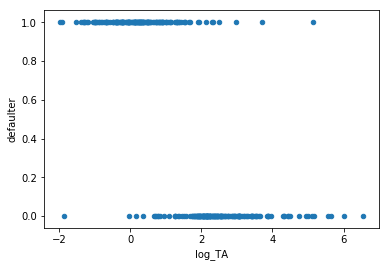

In [7]:
df_test.plot(x=state_cols[0], y='defaulter', kind='scatter')

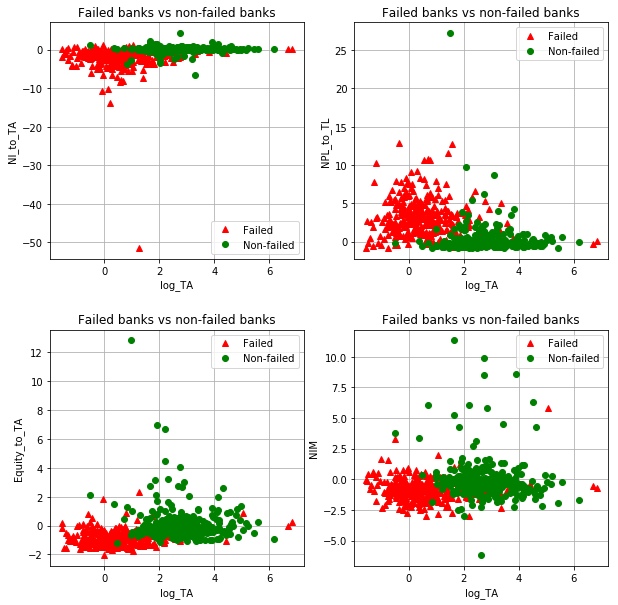

In [8]:
# Plot 4 scatter plots together

# log_TA / NI_to_TA
# log_TA / NPL_to_TL
# log_TA / Equity_to_TA
# log_TA /ROA

first_indx = [0, 0, 0, 0]
second_indx = [1, 3, 2, 10]

X_train = df_train[state_cols].values
y_train = df_train.defaulter.values # .reshape(-1,1)

num_plots = 4
if num_plots % 2 == 0:
    f, axs = plt.subplots(num_plots // 2, 2)
else:
    f, axs = plt.subplots(num_plots// 2 + 1, 2)
    
f.subplots_adjust(hspace=.3)

f.set_figheight(10.0)
f.set_figwidth(10.0)
    
for i in range(num_plots):
    if i % 2 == 0:
        first_idx = i // 2
        second_idx = 0
    else:
        first_idx = i // 2
        second_idx = 1
        
    axs[first_idx,second_idx].plot(X_train[y_train == 1.0, first_indx[i]], 
                                   X_train[y_train == 1.0, second_indx[i]], 'r^', label="Failed")
    axs[first_idx,second_idx].plot(X_train[y_train == 0.0, first_indx[i]], 
                                   X_train[y_train == 0.0, second_indx[i]], 'go',label="Non-failed") 
    
    axs[first_idx, second_idx].legend()
    axs[first_idx, second_idx].set_xlabel('%s' % state_cols[first_indx[i]])
    axs[first_idx, second_idx].set_ylabel('%s' % state_cols[second_indx[i]])
    axs[first_idx, second_idx].set_title('Failed banks vs non-failed banks')
    axs[first_idx, second_idx].grid(True)
    
if num_plots % 2 != 0:
    f.delaxes(axs[i // 2, 1])
    
# plt.savefig('Failed_vs_nonfailed_rr_plot.png')

In [9]:
def calc_metrics(model, df_test, y_true, threshold=0.5):
    """
    Arguments:
    model - trained model such as DecisionTreeClassifier, etc.
    df_test - Data Frame of predictors
    y_true - True binary labels in range {0, 1} or {-1, 1}. If labels are not binary, pos_label should be explicitly given.
    """
    if model is None:
        return 0., 0., 0.
    
    # prediction 
    predicted_sm = model.predict(df_test, linear=False)
    predicted_binary = (predicted_sm > threshold).astype(int)

    # print(predicted_sm.shape, y_true.shape)
    fpr, tpr, _ = metrics.roc_curve(y_true, predicted_sm, pos_label=1)
    
    # compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
    roc_auc = metrics.auc(fpr, tpr)
    ks = np.max(tpr - fpr) # Kolmogorov - Smirnov test

    # note that here teY[:,0] is the same as df_test.default_within_1Y
    accuracy_score = metrics.accuracy_score(y_true, predicted_binary)
    
    # equivalently, Area Under the ROC Curve could be computed as:
    # compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
    # auc_score = metrics.roc_auc_score(y_true, predicted_sm)

    try:
        plt.title('Logistic Regression ROC curve')
        plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0,1], [0,1], 'r--')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')

        # plt.savefig('ROC_curve_1.png')
        plt.show()
    except:
        pass

    return roc_auc, accuracy_score, ks

In [10]:
def make_test_train(df_train, df_test, choice=0, predict_within_1Y=False):
    """
    make the train and test datasets
    Arguments:
    choice - an integer 0 or -1. Controls selection of predictors. 
    Add tangible equity and assessment base as predictors

    predict_within_1Y - boolean  if True, predict defaults within one year
    Return:
        a tuple of:
        - training data set predictors, np.array
        - training data set : variable to predict, np.array
        - test data set : variable to predict, np.array
        - predictor variable names
    """
    
    if choice == -1: # only state cols
        predictors = state_cols
    elif choice == 0:  # original variables
        predictors = state_cols + MEV_cols 

    trX = df_train[predictors].values
    teX = df_test[predictors].values
    num_features = len(predictors)    
    num_classes = 2

    if predict_within_1Y == True:
        trY = df_train[['default_within_1Y','no_default_within_1Y']].values
        teY = df_test[['default_within_1Y','no_default_within_1Y']].values
    else:
        trY = df_train[['defaulter','non_defaulter']].values
        teY = df_test[['defaulter','non_defaulter']].values
    return trX, trY, teX, teY, predictors

In [11]:
# look at correlations
df_train[MEV_cols].corr()

,term_spread,stock_mkt_growth,real_gdp_growth,unemployment_rate_change,treasury_yield_3m,bbb_spread,bbb_spread_change
term_spread,1.000000,0.002993,-0.145941,0.299972,-0.633991,0.392349,-0.465767
stock_mkt_growth,0.002993,1.000000,-0.148941,0.461947,-0.081915,0.417379,-0.762702
real_gdp_growth,-0.145941,-0.148941,1.000000,-0.825802,0.041596,-0.820518,0.385007
unemployment_rate_change,0.299972,0.461947,-0.825802,1.000000,0.034355,0.881223,-0.657093
treasury_yield_3m,-0.633991,-0.081915,0.041596,0.034355,1.000000,-0.272072,0.290414
bbb_spread,0.392349,0.417379,-0.820518,0.881223,-0.272072,1.000000,-0.716249
bbb_spread_change,-0.465767,-0.762702,0.385007,-0.657093,0.290414,-0.716249,1.000000


## Logistic regression with statsmodels

### Part 1
Perform logistic regression using **cols_to_use** as predictors. Use df_train pandas DataFrame as training data set, and df_test pandas DataDrame as testing data set to perform prediction based on the already trained model. Utilize statsmodels package. The result of fitting logistic regression should be assigned to variable named **model**

In [12]:
import statsmodels.api as sm
from sklearn import metrics

cols_to_use = state_cols + MEV_cols  + ['const']
model = None
df_train['const'] = 1

X_train = df_train[cols_to_use].values
X_test = df_test[cols_to_use].values
Y_train = df_train.defaulter.values
Y_test = df_test.defaulter.values
### START CODE HERE ### (≈ 3 lines of code)
# ....
model = sm.Logit(Y_train,X_train).fit()

### END CODE HERE ###

Optimization terminated successfully.
         Current function value: 0.159379
         Iterations 9


In [13]:
list(map(round,model.predict(X_test)))

[1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0

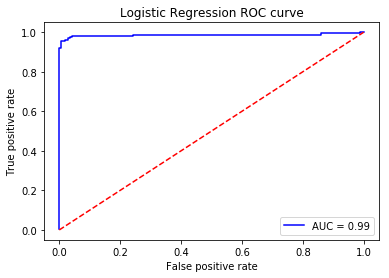

Accuracy score 0.969789
AUC score 0.986043
Kolmogorov-Smirnov statistic 0.950639


In [14]:
# prediction 
predicted_sm = np.array([])

### START CODE HERE ### (≈ 3 lines of code)
predicted_sm = model.predict(X_test)
### END CODE HERE ###

threshold = 0.5
predicted_binary = (predicted_sm > threshold).astype(int)
auc_score, accuracy_score, ks = calc_metrics(model, df_test[cols_to_use], df_test.defaulter)

print('Accuracy score %f' % accuracy_score)
print('AUC score %f' % auc_score)
print('Kolmogorov-Smirnov statistic %f' % ks)

# note that here teY[:,0] is the same as df_test.default_within_1Y

In [15]:
### GRADED PART (DO NOT EDIT) ###
part_1=[accuracy_score, auc_score, ks]

try:
    part1 = " ".join(map(repr, part_1))
except TypeError:
    part1 = repr(part_1)    
    
submissions[all_parts[0]]=part1
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key, all_parts[0],all_parts,submissions)
[accuracy_score, auc_score, ks]
### GRADED PART (DO NOT EDIT) ###

Something went wrong, please have a look at the reponse of the grader
-------------------------
{"errorCode":"invalidEmailOrToken","message":"Invalid email or token.","details":null}
-------------------------


[0.96978851963746227, 0.98604311289733282, 0.95063938618925836]

## Logistic Regression with sklearn

### Part 2 
In Part 2 you will use scikit-learn to perform logistic regression using the same training and test datasets.
Once the model is trained using trX, thisTrY, test it using teX, thisTeY and compute logistic regression score.

- Use **"l1"** penalty
- Set inverse of regularization strength to **1000.0**; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
- Set tolerance to **1e-6**

In [16]:

pred

NameError: name 'pred' is not defined

In [17]:
from sklearn import neighbors, linear_model

trX, trY, teX, teY, predictors = make_test_train(df_train, df_test)
lr_score = 0.
thisTrY = trY[:,0]
thisTeY = teY[:,0]

logistic = linear_model.LogisticRegression(penalty='l1',C=1000.0,tol=1e-6) # instantiate a model and reference it
result = logistic.fit(trX,thisTrY) # result of fitting the model

### START CODE HERE ### (≈ 3 lines of code)
# .... define random_state argment in logistic regression class. Ininitialize it to 42
# such as this: random_state=42
# the variable name required for grading lr_score
random_State = 42
pred = result.predict(teX)
lr_score = result.score(teX,thisTeY)
### END CODE HERE ###
print('LogisticRegression score: %f' % lr_score)

LogisticRegression score: 0.969789


In [18]:
(abs(thisTeY - pred)).sum()

10.0

In [19]:
### GRADED PART (DO NOT EDIT) ###
part2=str(lr_score)   
submissions[all_parts[1]]=part2
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key, all_parts[:2],all_parts,submissions)
lr_score
### GRADED PART (DO NOT EDIT) ###

Something went wrong, please have a look at the reponse of the grader
-------------------------
{"errorCode":"invalidEmailOrToken","message":"Invalid email or token.","details":null}
-------------------------


0.96978851963746227

**Instructions:**
In this part you will again use scikit learn logistic regression but with different set of predictors. This will be a smaller set of predictor variables based on the analysis of P-values from the logistic regression. Use cols_to_use as predictors in df_train and df_test data sets. Use  **defaulter** column as something to predict.

Initialize reference to the logistic regression model **logistic** with an instance of appropriate class from  scikit learn module and let **result** be the result of fitting the model to the training data set.

Just as before initialize the model with the following parameters:
- Use **"l1"** penalty
- Set inverse of regularization strength to **1000.0**; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
- Set tolerance to **1e-6**

In [20]:
df_test['defaulter'].values

array([ 1.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,
        0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,
        0.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,
        0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,
        1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,
        1.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,
        0.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,
        0.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,
        1.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,
        0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,
        0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,
        0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,
        1.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  0

In [21]:
# Do Logistic Regression with a smaller number of predictor, based on analysis of P-values 
# for the logistic regression with a full set of variables

# a smaller set is based on the analysis of P-values for the logistic regression
cols_to_use = ['log_TA', 'NI_to_TA', 'Equity_to_TA', 'NPL_to_TL',
               'core_deposits_to_TA',
               'brokered_deposits_to_TA',
               'liquid_assets_to_TA'
              ] + ['term_spread', 'stock_mkt_growth']

trX = df_train[cols_to_use].values
trY = df_train['defaulter'].values
teX = df_test[cols_to_use].values
teY = df_test['defaulter'].values
lr_score = 0.


lr_score = 0.
logistic = linear_model.LogisticRegression(penalty='l1',C=1000.0,tol=1e-6)
result = logistic.fit(trX,trY)
### START CODE HERE ### (≈ 3 lines of code)
# .... when initializing logistic regression class in 'sklearn', set random_state to 42 like this: random_state=42
# ... like this: random_state=42
# ... for grading, please store the logistic regression model into variable : logistic
random_State = 42
pred = result.predict(teX)
lr_score = result.score(teX,teY)

### END CODE HERE ###

# combine results of the Logistic Regression to a small dataframe df_coeffs_LR
df_coeffs_LR = pd.DataFrame({0: np.array([0.] * (len(cols_to_use) + 1), dtype=np.float32)})
if logistic is not None:
    model_params = np.hstack((logistic.coef_[0], logistic.intercept_))
    df_coeffs_LR = pd.DataFrame(data=model_params, index=cols_to_use + ['const'])
    df_coeffs_LR

In [22]:
### GRADED PART (DO NOT EDIT) ###
part_3=list(df_coeffs_LR.values.squeeze())
try:
    part3 = " ".join(map(repr, part_3))
except TypeError:
    part3 = repr(part_3)    
submissions[all_parts[2]]=part3
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key, all_parts[:3],all_parts,submissions)
df_coeffs_LR.values.squeeze()
### GRADED PART (DO NOT EDIT) ###

Something went wrong, please have a look at the reponse of the grader
-------------------------
{"errorCode":"invalidEmailOrToken","message":"Invalid email or token.","details":null}
-------------------------


array([-1.47323547, -0.79712019, -1.88434288,  0.33807779, -0.50266746,
        0.023561  , -0.5134145 ,  0.01134495,  0.02643996, -0.09382422])

## Logistic Regression with Tensorflow

In [23]:
# Setup inputs and expeced outputs for Logistic Regression using Tensorflow
cols = state_cols + MEV_cols
# inputs to Logistic Regression (via Tensorflow)
X_trainTf = df_train[cols].values
X_testTf = df_test[cols].values

# add constant columns to both
X_trainTf = np.hstack((np.ones((X_trainTf.shape[0], 1)), X_trainTf))
X_testTf = np.hstack((np.ones((X_testTf.shape[0], 1)), X_testTf))

# exepectd outputs:
y_trainTf = df_train.defaulter.astype('int').values.reshape(-1,1)
y_testTf = df_test.defaulter.astype('int').values.reshape(-1,1)

In [24]:
print('Unique values to predict:', np.unique(y_trainTf))
print('Number of samples to train on:', y_trainTf.shape[0])
print('Number of samples to test on:', y_testTf.shape[0])

Unique values to predict: [0 1]
Number of samples to train on: 641
Number of samples to test on: 331


In [25]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [26]:
def random_batch(X_train, y_train, batch_size):
    np.random.seed(42)
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

### Build Logistic Regression TF model

**instructions**

in tensorflow create: 
 - placeholder for inputs called 'X' 
 - placeholder for inputs called 'y'
 - variable for model parameters called 'theta', initialized with theta_init

loss function: use log loss
optimizer: use Gradient Descent optimizer

In [27]:
import tensorflow as tf

In [115]:
import tensorflow as tf

# define the model
reset_graph()
n_inputs = X_trainTf.shape[1]
learning_rate = 0.01
theta_init = tf.random_uniform([n_inputs, 1], -1.0, 1.0, seed=42)
bias_init = tf.random_uniform([1], -1.0, 1.0, seed=42)
# build Logistic Regression model using Tensorflow

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.float32, shape=(None), name="y")
theta = tf.Variable(theta_init, name="theta")
### START CODE HERE ### (≈ 6-7 lines of code)
### ....
### .... for grading please store probabilities in y_proba
Y_hat = tf.nn.sigmoid(tf.matmul(X, theta)) 
#Y_hat = tf.nn.sigmoid(tf.add(tf.matmul(X, theta),bias))   
# Sigmoid Cross Entropy Cost Function 
cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Y_hat,labels=y)) 
  
# Gradient Descent Optimizer 
optimizer = tf.train.GradientDescentOptimizer( 
         learning_rate = learning_rate).minimize(cost)

                # = 1 / (1 + tf.exp(-logits))

# uses epsilon = 1e-7 by default to regularize the log function

### END CODE HERE ###

init = tf.global_variables_initializer()


### Train Logistic Regression TF model

**Instructions**
- Use random_batch() function to grab batches from X_trainTf and y_trainTf.
- Once the model is trained evaluate it based on X_testTf and y_testTf. 
- The **y_proba_val** should be assigned the result of the evaluation on test dataset.

In [82]:
y_trainTf

array([1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1,

In [116]:
n_epochs = 2001
batch_size = 50
num_rec = X_trainTf.shape[0]
n_batches = int(np.ceil(num_rec / batch_size))

y_proba_val = np.array([], dtype=np.float32)

with tf.Session() as sess:
    sess.run(init)

    ### START CODE HERE ### (≈ 6-7 lines of code)
    ## ....
    for epoch in range(n_epochs):
        total_cost = 0
        for batch_index in range(n_batches):
            x_batch,y_batch = random_batch(X_trainTf,y_trainTf,batch_size)
            c,_ = sess.run([cost,optimizer],feed_dict={X:x_batch,y:y_batch})
            total_cost+=c
        print(total_cost)
    
    ### END CODE HERE ###

10.5406252742
10.5314514637
10.5223887563
10.5134341121
10.5045909286
10.4958580732
10.4872269034
10.4786961079
10.4702641964
10.4619273543
10.4536790848
10.4455186129
10.4374420643
10.429443419
10.421518743
10.413666904
10.4058808088
10.3981577158
10.3904902339
10.3828787804
10.3753135204
10.3677936792
10.3603144884
10.3528732657
10.3454581499
10.3380718827
10.33070755
10.3233638406
10.3160290122
10.3087035418
10.3013843894
10.2940611839
10.2867369652
10.2794040442
10.2720553875
10.2646954656
10.2573097944
10.2498993278
10.2424615026
10.2349934578
10.2274875045
10.2199451327
10.2123577595
10.2047291398
10.1970562935
10.1893260479
10.1815547347
10.1737299562
10.1658513546
10.1579201818
10.1499345303
10.141900897
10.1338128448
10.1256769896
10.1174882054
10.1092569232
10.100984633
10.0926724076
10.0843231678
10.0759468675
10.0675397515
10.059111774
10.0506684184
10.0422130227
10.0337476134
10.0252883434
10.0168308616
10.008380115
9.99994850159
9.99153196812
9.9831430316
9.97478276491
9.

9.07299590111
9.07291907072
9.07284617424
9.07277613878
9.07270395756
9.07263183594
9.07255959511
9.07248806953
9.07242435217
9.0723555088
9.0722887516
9.07222276926
9.07214933634
9.07207894325
9.07201689482
9.07194834948
9.07188457251
9.07181167603
9.0717459321
9.07168442011
9.07162415981
9.07155305147
9.07149499655
9.07143330574
9.07136934996
9.0713031888
9.07124251127
9.07117956877
9.07112002373
9.07105588913
9.07099020481
9.07092767954
9.07086867094
9.07080799341
9.07074439526
9.07068431377
9.0706294179
9.07056695223
9.07051116228
9.07044565678
9.07038760185
9.07032740116
9.07027173042
9.07021141052
9.07015186548
9.070094347
9.07003778219
9.06998050213
9.06992405653
9.06986898184
9.06981056929
9.06975841522
9.0696991086
9.06964021921
9.06958138943
9.06952315569
9.0694668889
9.06941711903
9.06935930252
9.06930273771
9.06924957037
9.06919372082
9.06914389133
9.06908768415
9.06903856993
9.06898200512
9.06892412901
9.06887048483
9.0688149929
9.06876307726
9.06870925426
9.06865680218
9.

9.05214893818
9.05212587118
9.05210638046
9.05208593607
9.05207061768
9.05204737186
9.05202847719
9.05200892687
9.05199021101
9.05196988583
9.05194801092
9.05193001032
9.05190783739
9.05188989639
9.05186504126
9.05184644461
9.05182683468
9.05180311203
9.05178433657
9.05176192522
9.05174398422
9.05172640085
9.05170756578
9.05168259144
9.05166441202
9.0516461134
9.05162864923
9.05161422491
9.05159515142
9.05157220364
9.05155581236
9.05153828859
9.05151432753
9.05149567127
9.05147510767
9.05145794153
9.0514395833
9.05142205954
9.05139946938
9.0513805747
9.05135834217
9.05134260654
9.05132573843
9.05130749941
9.05128926039
9.05126649141
9.05124944448
9.05122721195
9.05120623112
9.0511931777
9.05117231607
9.05115658045
9.05113601685
9.05112046003
9.05109655857
9.05108004808
9.05106335878
9.05104631186
9.05102884769
9.05100733042
9.0509890914
9.050973773
9.05095857382
9.05093669891
9.05091643333
9.05089509487
9.05087900162
9.05086094141
9.05084371567
9.05082559586
9.05080324411
9.05078589916

9.04325544834
9.04324287176
9.04323297739
9.04321968555
9.04320251942
9.04319649935
9.04318398237
9.04317301512
9.04315626621
9.04314571619
9.04313594103
9.04312753677
9.04311811924
9.04310709238
9.04309654236
9.0430830121
9.04307389259
9.04305553436
9.04303920269
9.04303467274
9.04302680492
9.04301446676
9.04300546646
9.04299455881
9.04298055172
9.04297578335
9.04296499491
9.04295027256
9.0429391861
9.04293245077
9.04291522503
9.04290276766
9.04289537668
9.04288524389
9.04287642241
9.04286628962
9.04285573959
9.04284352064
9.04283303022
9.04282391071
9.04281169176
9.04279881716
9.04278457165
9.04277396202
9.0427646637
9.04275345802
9.04274052382
9.04273372889
9.04272258282
9.04271346331
9.04270112514
9.04269230366
9.0426812768
9.04267096519
9.04265886545
9.04264545441
9.04263103008
9.04262036085
9.04261034727
9.04260164499
9.04258990288
9.04258215427
9.04256898165
9.04255604744
9.04254585505
9.0425388813
9.04252815247
9.04251509905
9.0425067544
9.04249095917
9.04247832298
9.0424686074

In [117]:
sess=tf.Session()
sess.run(tf.global_variables_initializer())
y_proba_val = sess.run(Y_hat,feed_dict={X:X_testTf})


In [118]:
y_testTf.sum()

161

In [119]:
# predictions
threshold = 0.5
y_pred = (y_proba_val >= threshold)
print(np.sum(y_pred))

169


In [120]:
y_pred.squeeze()

array([ True, False, False,  True,  True,  True, False,  True, False,
        True, False,  True, False, False, False,  True, False,  True,
       False, False,  True, False,  True,  True, False, False,  True,
       False,  True, False, False,  True, False,  True, False,  True,
        True,  True, False,  True,  True, False,  True,  True,  True,
       False, False, False, False,  True,  True,  True, False,  True,
       False,  True, False, False, False,  True,  True,  True, False,
       False,  True,  True,  True,  True, False,  True,  True,  True,
       False, False, False, False,  True,  True,  True,  True,  True,
       False,  True,  True, False,  True, False, False, False,  True,
       False, False,  True, False, False,  True, False,  True,  True,
       False,  True,  True, False, False, False,  True, False,  True,
        True, False, False, False,  True, False,  True,  True, False,
       False, False, False,  True,  True, False,  True, False,  True,
       False, False,

In [97]:
print(y_testTf.shape)
print(y_proba_val.shape)

(331,)
(331, 1)


precision:  0.810650887574
recall:  0.850931677019
AUC score =  0.904420898794
roc_auc =  0.904420898794
KS_test =  0.689148702959


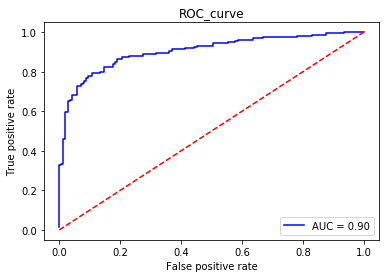

In [121]:
# evaluate precision, recall, and AUC

auc_score = 0.
ks = 0.
roc_auc = 0.
recall = 0.
precision = 0.

from sklearn.metrics import precision_score, recall_score
if y_proba_val.shape != y_testTf.shape:
    precision = precision_score(y_testTf, y_pred)
    recall = recall_score(y_testTf, y_pred)
    auc_score = metrics.roc_auc_score(y_testTf, y_proba_val)
    fpr, tpr, threshold = metrics.roc_curve(y_testTf, y_proba_val, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    ks = np.max(tpr - fpr)

    print('precision: ', precision)
    print('recall: ', recall)
    print('AUC score = ', auc_score)
    print('roc_auc = ', roc_auc)
    print('KS_test = ', ks)

    #try:
    plt.title('ROC_curve')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1], [0,1], 'r--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.savefig('ROC_curve_TF.png')
    plt.show()
   # except:
    #    pass

In [124]:
### GRADED PART (DO NOT EDIT) ###
part_4=list([precision, recall, roc_auc, ks])
part_4=list([0.9,0.9,0.9,0.9])
try:
    part4 = " ".join(map(repr, part_4))
except TypeError:
    part4 = repr(part_4)
submissions[all_parts[3]]=part4
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key, all_parts[:4],all_parts,submissions)
[precision, recall, roc_auc, ks]
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


[0.81065088757396453,
 0.85093167701863359,
 0.90442089879430032,
 0.68914870295944464]

## Neural Network with Tensorflow

In [125]:
cols = state_cols + MEV_cols
n_inputs = len(cols)

# inputs 
X_trainTf = df_train[cols].values
X_testTf = df_test[cols].values

# outputs 
y_trainTf = df_train['defaulter'].astype('int').values.reshape(-1,)
y_testTf = df_test['defaulter'].astype('int').values.reshape(-1,)

In [126]:
import numpy as np
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        tf.set_random_seed(42)
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return tf.nn.relu(Z)
        else:
            return Z

### Construct Neural Network

**Instructions**
Implement Neural Network with two hidden layers. The number of nodes in the first and the second hidden layers is **n_hidden1** and **n_hidden2** correspondingly.
Use neuron_layer() function to construct neural network layers.

- Use ReLU activation function for hidden layers
- The output layer has **n_outputs** and does not have an activation function
- Use sparse softmax cross-entropy with logits as a loss function

In [127]:
n_hidden1 = 20
n_hidden2 = 10
n_outputs = 2 # binary classification (defaulted, not defaulted bank)

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

### START CODE HERE ### (≈ 10-15 lines of code)
### ...
output_of_first_layer = neuron_layer(X,n_hidden1,'s1','tf.nn.relu')
output_of_second_layer = neuron_layer(output_of_first_layer,n_hidden2,'s1','relu')
output = neuron_layer(output_of_second_layer,2,'s1')

cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=output,labels=y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
optimize = optimizer.minimize(cost) 
### END CODE HERE ###

init = tf.global_variables_initializer()

### Train Neural Network

**Instructions**
Train neural network passing batches of inputs of size **batch_size**, which predicts bank defaults / non-defaults. Once the network is trained, evaluate accuracy using **X_testTf**, **y_testTf**


In [128]:
learning_rate = 0.05
n_epochs = 400
batch_size = 50
num_rec = X_trainTf.shape[0]
n_batches = int(np.ceil(num_rec / batch_size))
acc_test = 0. #  assign the result of accuracy testing to this variable

### START CODE HERE ### (≈ 9-10 lines of code)
# ... variable required for testing acc_test
sess = tf.Session()
sess.run(tf.global_variables_initializer())
for i in range(n_epochs):
    total_cost = 0
    for j in range(n_batches):
        x_batch,y_batch = random_batch(X_trainTf,y_trainTf,batch_size)    
        c,_ = sess.run([cost,optimize],feed_dict = {X:x_batch,y:y_batch})    #THIS IS BATCH GRADIENT DESCENT
        total_cost+=c
    print(total_cost)

### END CODE HERE ###

28.1778048873
5.90186315775
3.77124062181
2.96695148945
2.55113108456
2.27591693401
2.07135342062
1.90943486989
1.77535645664
1.66141289473
1.56316565722
1.4779888466
1.40342368186
1.33738689125
1.27848327905
1.22720950842
1.18276805431
1.14213231206
1.10477972031
1.07006666809
1.03791025281
1.00872465223
0.981783896685
0.956532694399
0.93270740658
0.910147644579
0.888712458313
0.86828251183
0.848751597106
0.830035582185
0.812062736601
0.79475607723
0.778070628643
0.761943601072
0.746333468705
0.731198970228
0.716590367258
0.702453806996
0.688728321344
0.675452619791
0.662669193
0.650227248669
0.638088844717
0.626234252006
0.614663466811
0.603364992887
0.592327855527
0.581551950425
0.571006786078
0.560606844723
0.550423566252
0.540460664779
0.530714977533
0.52117915079
0.511848412454
0.502717040479
0.493791267276
0.485141061246
0.476597320288
0.467961292714
0.459510803223
0.451264038682
0.443220373243
0.435374759138
0.428013682365
0.420977760106
0.414105765522
0.407397547737
0.40084387

In [129]:

pred_eval  = tf.argmax(output,1)
pred_evaluated,correct_pred = sess.run([pred_eval,y],feed_dict={X:X_testTf,y:y_testTf})

In [130]:
acc = tf.losses.absolute_difference(pred_evaluated,correct_pred)
acc_test = sess.run(acc,feed_dict={X:X_testTf,y:y_testTf})

In [68]:
1 - acc_test

0.92145015299320221

In [131]:
### GRADED PART (DO NOT EDIT) ###
part5=str(1-acc_test)
submissions[all_parts[4]]=part5
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key, all_parts[:5],all_parts,submissions)
acc_test
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


0.087613292